# Дмитрий Ильин
# Методы обучения с подкреплением, ДЗ №1

In [436]:
import io
import base64
import random
import numpy as np
from itertools import product
import matplotlib.pyplot as plt
from PIL import Image, ImageSequence
from IPython.display import display, HTML

# Описание

##Состояния
Состояния описываются массивом из N чисел, где каждое число представляет состояние пассажира (0 - ожидает перевозки, 1 - перевезен, 2 - последний перевезенный пассажир). N равно общему числу пассажиров.\
Изначальное состояние - массив и 0. Последний перевезенный пассажир может быть только один, конечно же, поэтому состояния с количеством двоек больше одного невозможны.\
Также невозможны состояния, где полностью отсутствуют последний перевезенный пассажир, кроме изначального, где все 0, то есть [0, 0, 1, 0] - это невозможное состояние.\
Из состояния среды можно извлечь позицию такси, если в состоянии все 0, то положение такси берется из taxi_start_position, в остальных случаях оно равняется положению цели последнего перевезенного пассажира.

##Действия
Действия представлены числами от 0 до N-1, где каждое число соответствует перевозке конкретного пассажира. Возможные действия в каждом состоянии зависят от того, какие пассажиры уже перевезены (т.е. для пассажира, который уже перевезен или является последним перевезенным, действие перевозки недоступно).

##Награды
Награда за выполнение действия рассчитывается на основе штрафа за перемещение (который зависит от манхэтеннского расстояния между текущей позицией такси, позицией пассажира и его целью) и фиксированных наград за подбор пассажира и его доставку.

##Переходы между состояниями
Переходы между состояниями осуществляются посредством выполнения действий. Выбор действия перевозки пассажира приводит к изменению его состояния с 0 на 2 (если другой пассажир уже был доставлен, его состояние меняется с 2 на 1). Таким образом, из каждого состояния возможен переход в несколько других состояний в зависимости от выбранного действия.

# Реализация

In [450]:
class TaxiTransportationMDP:
    def __init__(self, config=None):
        if config is not None:
            self.world_side_length = config["world_side_length"] # Длина стороны мира, если, например, равна 5, то у нас будет поле 5x5
            self.passengers = config["passengers"]
            self.taxi_start_position = config["taxi_start_position"]
            self.targets = config["targets"]
            self.colors = config["colors"]
            self.move_fine = config["move_fine"]
            self.pick_up_reward = config["pick_up_reward"]
            self.drop_off_reward = config["drop_off_reward"]
        else:
            self.world_side_length = 5
            self.colors = ["blue", "green", "orange", "purple"]
            self.move_fine = -1
            self.pick_up_reward = 10
            self.drop_off_reward = 10
            self.generate_random_positions()

        self.action_space = len(self.passengers) # Число возможных действий равно числу пассажиров
        self.all_possible_states = self._generate_all_possible_states()


    def generate_random_positions(self):
        self.taxi_start_position = (random.randint(0, self.world_side_length - 1), random.randint(0, self.world_side_length - 1))
        self.passengers = []
        used_positions = set(self.taxi_start_position)
        for _ in range(4):
            while True:
                position = (random.randint(0, self.world_side_length - 1), random.randint(0, self.world_side_length - 1))
                if position not in used_positions and position != self.taxi_start_position:
                    self.passengers.append({chr(ord("A") + len(self.passengers)): position})
                    used_positions.add(position)
                    break
        self.targets = []
        for _ in range(4):
            while True:
                position = (random.randint(0, self.world_side_length - 1), random.randint(0, self.world_side_length - 1))
                if position not in used_positions:
                    self.targets.append({chr(ord("a") + len(self.targets)): position})
                    used_positions.add(position)
                    break


    def _filter_combinations(self, combo):
        #Флаг, означающий последнего доставленного пассажира (2), может быть только один
        if combo.count(2) > 1:
            return False
        #Состояние, где нет ни одного последнего доставленного пассажира, кроме изначального, невозможно
        if combo.count(0) < self.action_space and combo.count(2) < 1:
            return False
        return True


    def _generate_all_possible_states(self):
        all_combinations = list(product(range(3), repeat=self.action_space))

        return [combo for combo in all_combinations if self._filter_combinations(combo)]


    def print_all_possible_states(self):
        for i in range(len(self.all_possible_states)):
            print(f"{i}: {self.all_possible_states[i]}")


    def state_to_index(self, state):
        return self.all_possible_states.index(state)


    def index_to_state(self, state_index):
        return self.all_possible_states[state_index]


    def get_taxi_position(self, state_index):
        state = self.index_to_state(state_index)
        if 2 in state:
            return list(self.targets[state.index(2)].values())[0]
        else:
            return self.taxi_start_position


    def get_possible_actions(self, state_index):
        state = self.index_to_state(state_index)
        return tuple(i for i, x in enumerate(state) if x == 0)


    def apply_action(self, state_index, action):
        state = self.index_to_state(state_index)
        next_state = tuple(2 if i == action else (1 if x == 2 else x) for i, x in enumerate(state))

        return self.state_to_index(next_state)


    def is_action_possible(self, state_index, action):
        return action in self.get_possible_actions(state_index)


    def calculate_reward(self, state_index, action):
        if not self.is_action_possible(state_index, action):
            return -1

        taxi_position = self.get_taxi_position(state_index)
        passenger_position = list(self.passengers[action].values())[0]
        target_position = list(self.targets[action].values())[0]
        fine = self.move_fine * (self.calculate_distance(taxi_position, passenger_position) + self.calculate_distance(passenger_position, target_position))

        return fine + self.pick_up_reward + self.drop_off_reward #10 баллов за подбор пассажира + 10 за перевозку


    def calculate_distance(self, point1, point2):
        return abs(point1[0] - point2[0]) + abs(point1[1] - point2[1])


    def is_all_passengers_transported(self, state_index):
        return 0 not in self.index_to_state(state_index)


    def policy_iteration(self, discount_factor=0.95, theta=0.0001):
        policy = np.zeros(len(self.all_possible_states), dtype=int)
        V = np.zeros(len(self.all_possible_states))

        def one_step_lookahead(state_index, V):
            actions_values = np.full(self.action_space, -1e5) # Используем большое отрицательное число
            for action in self.get_possible_actions(state_index):
                if self.is_action_possible(state_index, action):
                    next_state = self.apply_action(state_index, action)
                    reward = self.calculate_reward(state_index, action)
                    actions_values[action] = reward + discount_factor * V[next_state]
            return actions_values

        policy_stable = False
        while not policy_stable:
            # Оценка стратегии
            while True:
                delta = 0
                for s in range(len(V)):
                    v = V[s]
                    V[s] = max(one_step_lookahead(s, V))
                    delta = max(delta, abs(v - V[s]))
                if delta < theta:
                    break

            # Улучшение стратегии
            policy_stable = True
            for s in range(len(policy)):
                chosen_action = policy[s]
                action_values = one_step_lookahead(s, V)
                best_action = np.argmax(action_values)
                if chosen_action != best_action:
                    policy_stable = False
                policy[s] = best_action

        self.policy = policy


    def print_all_possible_states_with_policy(self):
        for i in range(len(self.all_possible_states)):
            passenger_letter = list(self.passengers[self.policy[i]].keys())[0]
            print(f"{i}: {self.all_possible_states[i]} -> {passenger_letter} ({self.policy[i]}) -> {self.apply_action(i, self.policy[i])} (награда {self.calculate_reward(i, self.policy[i])})")


    def draw_path(self, ax, start, end, color):
        ax.plot([start[0]+0.5, end[0]+0.5], [start[1]+0.5, start[1]+0.5], color=color)  # Горизонтальный сегмент
        ax.plot([end[0]+0.5, end[0]+0.5], [start[1]+0.5, end[1]+0.5], color=color)  # Вертикальный сегмент


    def visualize_state(self, state_index, draw_route=False):
        grid = np.zeros((self.world_side_length, self.world_side_length))

        # Настраиваем внешний вид графика
        fig, ax = plt.subplots()
        ax.set_xlim(0, self.world_side_length)
        ax.set_ylim(0, self.world_side_length)
        plt.xticks(np.arange(0, self.world_side_length, 1))
        plt.yticks(np.arange(0, self.world_side_length, 1))
        plt.grid(True)

        ax.set_aspect('equal')
        ax.invert_yaxis()

        taxi_position = self.get_taxi_position(state_index)

        if draw_route:
            passenger_index = self.policy[state_index]
            passenger_position = list(self.passengers[passenger_index].values())[0]
            target_position = list(self.targets[passenger_index].values())[0]
            # Рисуем путь от такси к пассажиру
            self.draw_path(ax, taxi_position, passenger_position, 'yellow')
            # Рисуем путь от пассажира к его цели
            self.draw_path(ax, passenger_position, target_position, 'yellow')

        # Рисуем такси
        ax.text(taxi_position[0] + 0.5, taxi_position[1] + 0.5, 'T', va='center', ha='center', color='red', fontsize=15)

        # Получаем текущее состояние
        state = self.index_to_state(state_index)

        for passenger_index, passenger_status in enumerate(state):
            if passenger_status == 0:  # Пассажир еще не перевезен
                passenger_key = list(self.passengers[passenger_index].keys())[0]
                target_key = list(self.targets[passenger_index].keys())[0]
                passenger_position = list(self.passengers[passenger_index].values())[0]
                target_position = list(self.targets[passenger_index].values())[0]

                # Рисуем пассажиров и их цели
                ax.text(passenger_position[0] + 0.5, passenger_position[1] + 0.5, passenger_key, va='center', ha='center', color=self.colors[passenger_index], fontsize=15)
                ax.text(target_position[0] + 0.5, target_position[1] + 0.5, target_key, va='center', ha='center', color=self.colors[passenger_index], fontsize=15)

        # Создаем изображение
        buffer = io.BytesIO()
        plt.savefig(buffer, format='png')
        plt.close(fig)
        buffer.seek(0)
        image_pil = Image.open(buffer)

        return image_pil


    def visualize_best_strategy(self):
        images = []
        state_index = 0
        while True:
            images.append(mdp.visualize_state(state_index, False))
            if self.is_all_passengers_transported(state_index):
                break
            images.append(mdp.visualize_state(state_index, True))
            state_index = self.apply_action(state_index, self.policy[state_index])

        gif_buffer = io.BytesIO()
        images[0].save(gif_buffer, save_all=True, append_images=images[1:], format='GIF', duration=800, loop=0)
        gif_buffer.seek(0)
        gif_pil = Image.open(gif_buffer)
        gif_display = "<img src='data:image/gif;base64,{}'/>".format(base64.b64encode(gif_buffer.getvalue()).decode())
        display(HTML(gif_display))



# Проверка №1

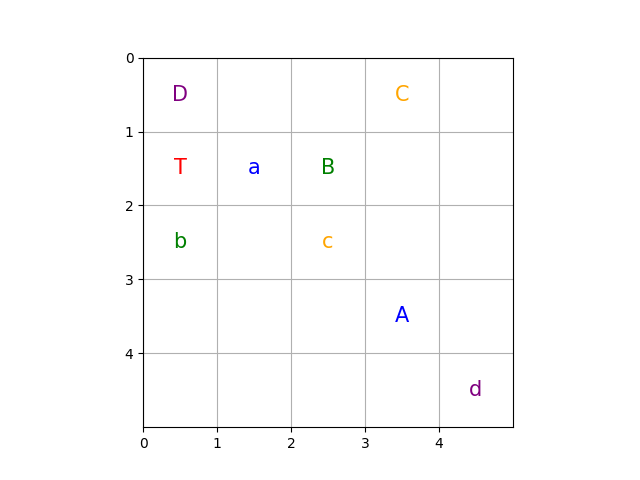

In [441]:
config = {
    "world_side_length": 5,
    "taxi_start_position": (0, 1),
    "passengers": [{"A": (3, 3)}, {"B": (2, 1)}, {"C": (3, 0)}, {"D": (0, 0)}],
    "targets": [{"a": (1, 1)}, {"b": (0, 2)}, {"c": (2, 2)}, {"d": (4, 4)}],
    "colors": ['blue', 'green', 'orange', 'purple'],
    "move_fine": -1,
    "pick_up_reward": 10,
    "drop_off_reward": 10
}

mdp = TaxiTransportationMDP(config)
mdp.policy_iteration()
mdp.visualize_state(0)

In [442]:
mdp.print_all_possible_states_with_policy()

0: (0, 0, 0, 0) -> D (3) -> 1 (награда 11)
1: (0, 0, 0, 2) -> A (0) -> 26 (награда 14)
2: (0, 0, 1, 2) -> A (0) -> 28 (награда 14)
3: (0, 0, 2, 0) -> A (0) -> 27 (награда 14)
4: (0, 0, 2, 1) -> A (0) -> 28 (награда 14)
5: (0, 1, 0, 2) -> A (0) -> 30 (награда 14)
6: (0, 1, 1, 2) -> A (0) -> 32 (награда 14)
7: (0, 1, 2, 0) -> A (0) -> 31 (награда 14)
8: (0, 1, 2, 1) -> A (0) -> 32 (награда 14)
9: (0, 2, 0, 0) -> D (3) -> 5 (награда 10)
10: (0, 2, 0, 1) -> A (0) -> 30 (награда 12)
11: (0, 2, 1, 0) -> D (3) -> 6 (награда 10)
12: (0, 2, 1, 1) -> A (0) -> 32 (награда 12)
13: (1, 0, 0, 2) -> C (2) -> 16 (награда 12)
14: (1, 0, 1, 2) -> B (1) -> 24 (награда 12)
15: (1, 0, 2, 0) -> B (1) -> 23 (награда 16)
16: (1, 0, 2, 1) -> B (1) -> 24 (награда 16)
17: (1, 1, 0, 2) -> C (2) -> 20 (награда 12)
18: (1, 1, 1, 2) -> A (0) -> 32 (награда -1)
19: (1, 1, 2, 0) -> D (3) -> 18 (награда 8)
20: (1, 1, 2, 1) -> A (0) -> 32 (награда -1)
21: (1, 2, 0, 0) -> D (3) -> 17 (награда 10)
22: (1, 2, 0, 1) -> C (2


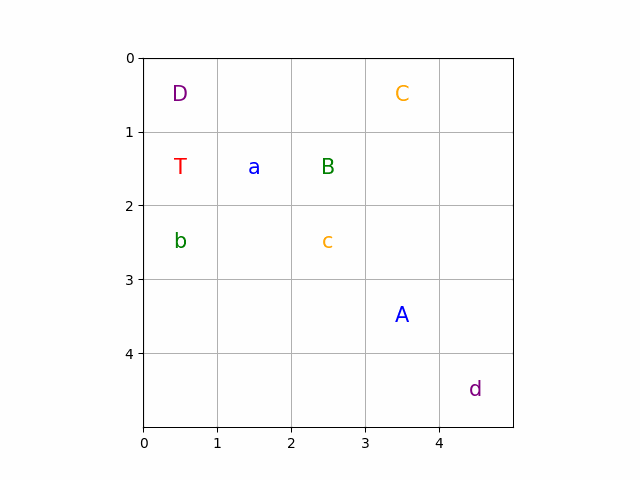

In [443]:
mdp.visualize_best_strategy()

# Проверка №2

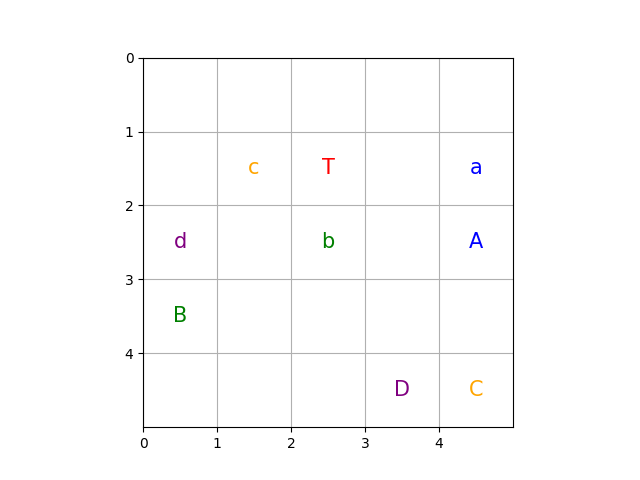

In [451]:
mdp = TaxiTransportationMDP()
mdp.policy_iteration()
mdp.visualize_state(0)

In [452]:
mdp.print_all_possible_states_with_policy()

0: (0, 0, 0, 0) -> D (3) -> 1 (награда 11)
1: (0, 0, 0, 2) -> B (1) -> 10 (награда 16)
2: (0, 0, 1, 2) -> B (1) -> 12 (награда 16)
3: (0, 0, 2, 0) -> D (3) -> 2 (награда 10)
4: (0, 0, 2, 1) -> B (1) -> 12 (награда 14)
5: (0, 1, 0, 2) -> A (0) -> 30 (награда 15)
6: (0, 1, 1, 2) -> A (0) -> 32 (награда 15)
7: (0, 1, 2, 0) -> A (0) -> 31 (награда 15)
8: (0, 1, 2, 1) -> A (0) -> 32 (награда 15)
9: (0, 2, 0, 0) -> A (0) -> 29 (награда 17)
10: (0, 2, 0, 1) -> A (0) -> 30 (награда 17)
11: (0, 2, 1, 0) -> A (0) -> 31 (награда 17)
12: (0, 2, 1, 1) -> A (0) -> 32 (награда 17)
13: (1, 0, 0, 2) -> B (1) -> 22 (награда 16)
14: (1, 0, 1, 2) -> B (1) -> 24 (награда 16)
15: (1, 0, 2, 0) -> B (1) -> 23 (награда 14)
16: (1, 0, 2, 1) -> B (1) -> 24 (награда 14)
17: (1, 1, 0, 2) -> C (2) -> 20 (награда 8)
18: (1, 1, 1, 2) -> A (0) -> 32 (награда -1)
19: (1, 1, 2, 0) -> D (3) -> 18 (награда 10)
20: (1, 1, 2, 1) -> A (0) -> 32 (награда -1)
21: (1, 2, 0, 0) -> D (3) -> 17 (награда 12)
22: (1, 2, 0, 1) -> C (


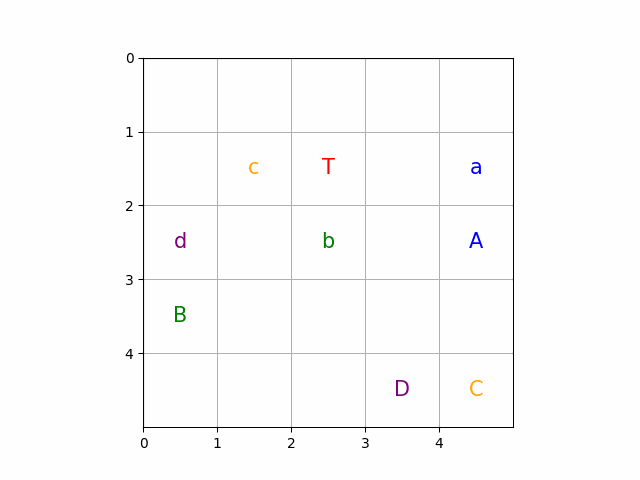

In [453]:
mdp.visualize_best_strategy()

#Проверка №3

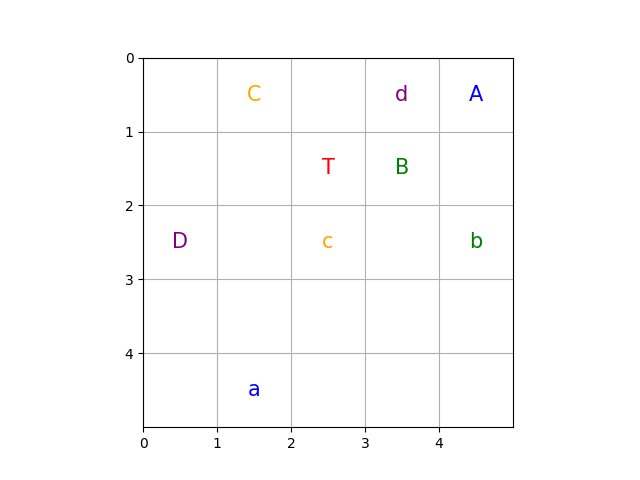

In [456]:
mdp = TaxiTransportationMDP()
mdp.policy_iteration()
mdp.visualize_state(0)

In [457]:
mdp.print_all_possible_states_with_policy()

0: (0, 0, 0, 0) -> C (2) -> 3 (награда 15)
1: (0, 0, 0, 2) -> C (2) -> 4 (награда 15)
2: (0, 0, 1, 2) -> B (1) -> 12 (награда 17)
3: (0, 0, 2, 0) -> D (3) -> 2 (награда 13)
4: (0, 0, 2, 1) -> B (1) -> 12 (награда 16)
5: (0, 1, 0, 2) -> A (0) -> 30 (награда 12)
6: (0, 1, 1, 2) -> A (0) -> 32 (награда 12)
7: (0, 1, 2, 0) -> D (3) -> 6 (награда 13)
8: (0, 1, 2, 1) -> A (0) -> 32 (награда 9)
9: (0, 2, 0, 0) -> A (0) -> 29 (награда 11)
10: (0, 2, 0, 1) -> A (0) -> 30 (награда 11)
11: (0, 2, 1, 0) -> A (0) -> 31 (награда 11)
12: (0, 2, 1, 1) -> A (0) -> 32 (награда 11)
13: (1, 0, 0, 2) -> C (2) -> 16 (награда 15)
14: (1, 0, 1, 2) -> B (1) -> 24 (награда 17)
15: (1, 0, 2, 0) -> D (3) -> 14 (награда 13)
16: (1, 0, 2, 1) -> B (1) -> 24 (награда 16)
17: (1, 1, 0, 2) -> C (2) -> 20 (награда 15)
18: (1, 1, 1, 2) -> A (0) -> 32 (награда -1)
19: (1, 1, 2, 0) -> D (3) -> 18 (награда 13)
20: (1, 1, 2, 1) -> A (0) -> 32 (награда -1)
21: (1, 2, 0, 0) -> D (3) -> 17 (награда 11)
22: (1, 2, 0, 1) -> C (2)


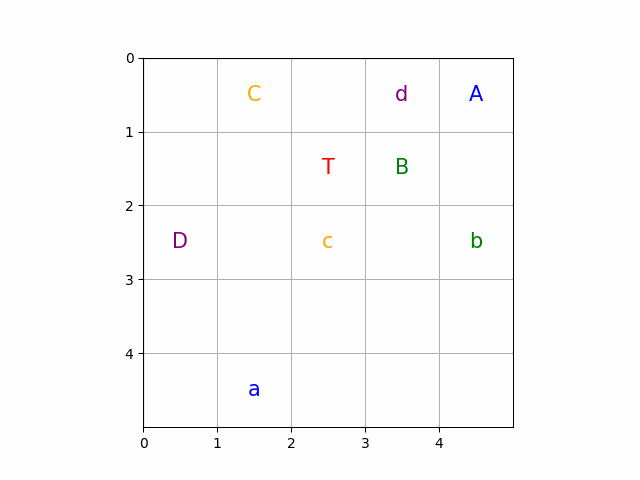

In [458]:
mdp.visualize_best_strategy()